In [16]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
result_dir='problem_classification_ela_results'
seeds=[200,400,600,800,1000]
visualizations_dir='ela_problem_classification_visualizations'
seed_mapping={index:seed for index,seed in enumerate(seeds)}

In [19]:
os.makedirs(visualizations_dir,exist_ok=True)

In [3]:
all_algorithms=['DE','ES','PSO']
all_stats=['min','max','mean','std']
all_dimensions=[3,5,10,20]

In [4]:
def get_global_file_name(dimension,algorithms, iteration_start,iteration_end, train_on_seed,seed, difference,stat=None):
    file_name=f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_1000_{"train" if train_on_seed else "test"}_on_seed_{seed}{"_differenced" if difference else ""}'
    if stat is None:
        return os.path.join(result_dir,file_name)
    else:
        return os.path.join(result_dir,f'stat_{stat}_' + file_name)


def get_visualization_output_name_without_seed(dimension,algorithms, iteration_start,iteration_end, train_on_seed, difference):
    return os.path.join(visualizations_dir,f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_1000_{"train" if train_on_seed else "test"}_on_seed{"_differenced" if difference else ""}')

In [5]:
def get_seed_accuracies_df(dimension,algorithm, iteration_start, iteration_end, train_on_seed, difference, seeds, stat=None):
    seed_accuracies=[]
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(dimension,algorithm, iteration_start,iteration_end, train_on_seed,train_seed, difference, stat)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, index_col=[0], compression='zip').rename(columns={'seed':'test_seed'}) 
            test_df_fold['fold']=fold
            test_df_fold['train_seed']=train_seed
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])



        for test_seed in seeds:
            for fold in range(0,10):
                seed_preds_df=test_df.query('test_seed==@test_seed and fold==@fold')
                seed_accuracies+=[(accuracy_score(seed_preds_df['y'], seed_preds_df['preds']), train_seed, test_seed, fold)]


    if len(seed_accuracies)>0:
        seed_accuracy_df=pd.DataFrame(seed_accuracies)
        seed_accuracy_df.columns=['accuracy','train_seed','test_seed','fold']
        return seed_accuracy_df, test_df_all
    return None

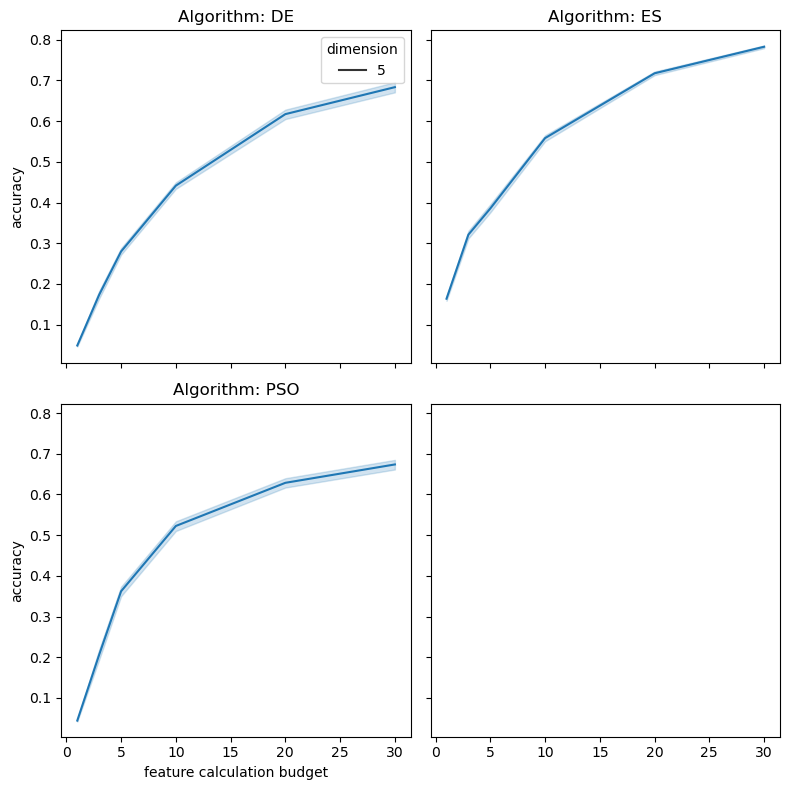

In [13]:
for index,dimension in enumerate([5]):
    
    fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True)
    for index, algorithm in enumerate(all_algorithms):
        accuracies=all_accuracies.query('algorithm==@algorithm and dimension==@dimension')
        ax=axes[int(index/2), index%2] if type(axes) is np.ndarray else axes
        ax.set_title(f'Algorithm: {algorithm}')
        sns.lineplot(x="feature calculation budget", y="accuracy", style="dimension",ax=ax,
                 data=accuracies)
        if index != 0:
            ax.get_legend().remove()
    plt.tight_layout()

    #plt.savefig(os.path.join(visualizations_dir,f'accuracies_per_statistic.pdf'))
    plt.show()

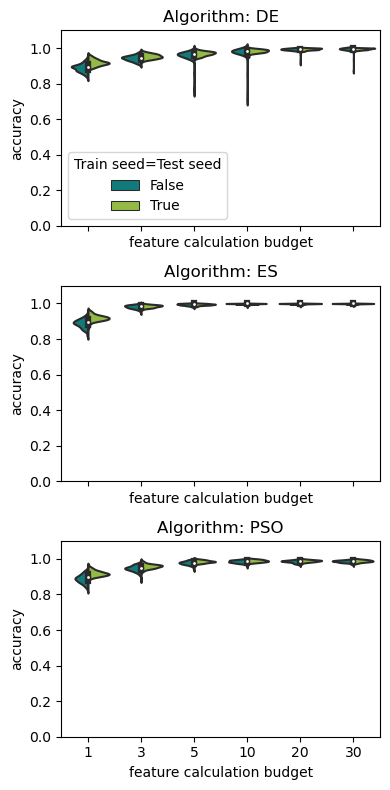

In [20]:
results_per_iteration=[]
all_accuracies=pd.DataFrame()
all_algorithms=['DE','ES','PSO']
for dimension in [5]: #
    all_accuracies=pd.DataFrame()
    for algorithm in all_algorithms:
        for train_on_seed_1 in [True]:
            for difference_1 in [False]:
                for end_iteration in [0,2,4,9,19,29]:
                    seed_accuracy_df,_ = get_seed_accuracies_df(dimension,algorithm, 0, end_iteration, train_on_seed_1, difference_1, seeds)
                    seed_accuracy_df['feature calculation budget']=end_iteration+1
                    seed_accuracy_df['algorithm']=algorithm
                    seed_accuracy_df['dimension']=dimension
                    all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])

    
    all_accuracies['Train seed=Test seed']=all_accuracies.apply(lambda row: row['train_seed']==row['test_seed'], axis=1)
    fig, axes = plt.subplots(len(all_algorithms),1, figsize=(4,8), sharex=True, sharey=True)
    for algorithm_index, algorithm in enumerate(all_algorithms):
        algorithm_accuracies=all_accuracies.query('algorithm==@algorithm')
        ax=axes[algorithm_index] if type(axes) is np.ndarray else axes
        ax.set_title(f'Algorithm: {algorithm}')
        sns.violinplot(data=algorithm_accuracies, x="feature calculation budget", y="accuracy", hue='Train seed=Test seed', split=True, palette=color_palette[1:3], ax=ax)
        ax.set_ylim(bottom=0, top=1.1)
        if algorithm_index != 0:
            ax.get_legend().remove()
    plt.tight_layout()
    
    plt.savefig(os.path.join(visualizations_dir,f'dim_{dimension}_accuracies_all_algorithms.pdf'))
    plt.show()

In [50]:
all_accuracies.to_csv(f'{visualizations_dir}/ela_accuracies.csv')

In [86]:
ela_accuracies.groupby(['feature calculation budget','algorithm']).median()['accuracy']

feature calculation budget  algorithm
1                           DE           0.041667
                            ES           0.254167
                            PSO          0.041667
3                           DE           0.089583
                            ES           0.550000
                            PSO          0.162500
5                           DE           0.170833
                            ES           0.633333
                            PSO          0.329167
10                          DE           0.322917
                            ES           0.733333
                            PSO          0.472917
20                          DE           0.512500
                            ES           0.837500
                            PSO          0.566667
30                          DE           0.600000
                            ES           0.879167
                            PSO          0.612500
40                          DE           0.654167
            

In [87]:
dynamorep_accuracies.groupby(['feature calculation budget','normalize_y','algorithm']).median()['accuracy']

feature calculation budget  normalize_y  algorithm
1                           False        DE           0.604167
                                         ES           0.629167
                                         PSO          0.629167
                            True         DE           0.258333
                                         ES           0.279167
                                         PSO          0.279167
3                           False        DE           0.687500
                                         ES           0.962500
                                         PSO          0.808333
                            True         DE           0.433333
                                         ES           0.787500
                                         PSO          0.629167
5                           False        DE           0.783333
                                         ES           0.975000
                                         PSO          0.904167
    

In [89]:
ela_accuracies

,accuracy,train_seed,test_seed,fold,feature calculation budget,algorithm,dimension,Train seed=Test seed
0,0.229167,200,200,0,1,DE,5,True
1,0.237500,200,200,1,1,DE,5,True
2,0.258333,200,200,2,1,DE,5,True
3,0.250000,200,200,3,1,DE,5,True
4,0.287500,200,200,4,1,DE,5,True
...,...,...,...,...,...,...,...,...
245,0.870833,1000,1000,5,50,PSO,5,True
246,0.829167,1000,1000,6,50,PSO,5,True
247,0.791667,1000,1000,7,50,PSO,5,True
248,0.875000,1000,1000,8,50,PSO,5,True


/tmp/ipykernel_226466/2786452140.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ela_accuracies_by_iteration=ela_accuracies.groupby(['feature calculation budget']).median()['accuracy']
/tmp/ipykernel_226466/2786452140.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dynamorep_accuracies_by_iteration_and_normalize=dynamorep_accuracies.groupby(['feature calculation budget','normalize_y']).median()['accuracy']
/tmp/ipykernel_226466/2786452140.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare_accuracie

     accuracy  train_seed  test_seed  fold  feature calculation budget  \
10   0.033333         200        400     0                           1   
11   0.041667         200        400     1                           1   
12   0.033333         200        400     2                           1   
13   0.041667         200        400     3                           1   
14   0.058333         200        400     4                           1   
..        ...         ...        ...   ...                         ...   
235  0.650000        1000        800     5                          50   
236  0.666667        1000        800     6                          50   
237  0.633333        1000        800     7                          50   
238  0.679167        1000        800     8                          50   
239  0.591667        1000        800     9                          50   

    algorithm  dimension  Train seed=Test seed  
10         DE          5                 False  
11         DE

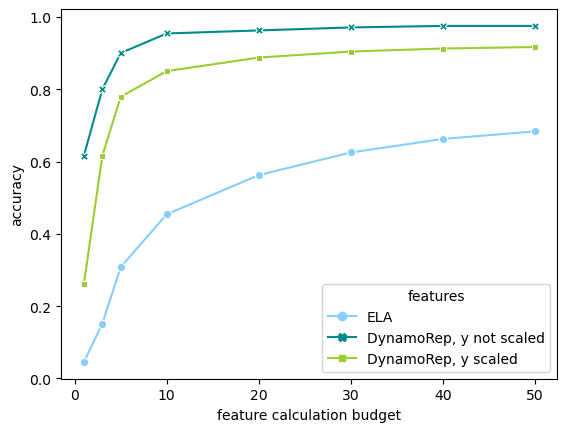

In [94]:
ela_accuracies=all_accuracies[all_accuracies["Train seed=Test seed"]!=True]
ela_accuracies_by_iteration=ela_accuracies.groupby(['feature calculation budget']).median()['accuracy']
print(ela_accuracies)
dynamorep_accuracies=pd.read_csv(f'problem_classification_visualizations/accuracies_dim_5.csv',index_col=0)
dynamorep_accuracies=dynamorep_accuracies[dynamorep_accuracies["Train seed=Test seed"]!=True]
print(dynamorep_accuracies)
dynamorep_accuracies_by_iteration_and_normalize=dynamorep_accuracies.groupby(['feature calculation budget','normalize_y']).median()['accuracy']


dynamorep_accuracies_by_iteration_and_normalize_i = dynamorep_accuracies_by_iteration_and_normalize.reset_index()
dynamorep_accuracies_by_iteration_and_normalize_i.columns=['feature calculation budget','scale y', 'accuracy']
dynamorep_accuracies_by_iteration_and_normalize_i['features']=dynamorep_accuracies_by_iteration_and_normalize_i['scale y'].apply(lambda x: 'DynamoRep, y scaled' if x==True else 'DynamoRep, y not scaled')


ela_accuracies_by_iteration=ela_accuracies_by_iteration.reset_index()
ela_accuracies_by_iteration.columns=['feature calculation budget','accuracy']
ela_accuracies_by_iteration['features']='ELA'
compare_accuracies=ela_accuracies_by_iteration.append(dynamorep_accuracies_by_iteration_and_normalize_i)

plt.figure()
sns.lineplot(x="feature calculation budget", y="accuracy",
                     hue="features",style="features",markers=True,dashes=False,
                     data=compare_accuracies,palette=color_palette)
#plt.show()
plt.savefig(f'{visualizations_dir}/ela_comparison_dim_5_generelization.pdf')

/tmp/ipykernel_226466/916659586.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ela_accuracies_by_iteration=ela_accuracies.groupby(['feature calculation budget']).median()['accuracy']
/tmp/ipykernel_226466/916659586.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dynamorep_accuracies_by_iteration_and_normalize=dynamorep_accuracies.groupby(['feature calculation budget','normalize_y']).median()['accuracy']
/tmp/ipykernel_226466/916659586.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare_accuracies=e

     accuracy  train_seed  test_seed  fold  feature calculation budget  \
0    0.229167         200        200     0                           1   
1    0.237500         200        200     1                           1   
2    0.258333         200        200     2                           1   
3    0.250000         200        200     3                           1   
4    0.287500         200        200     4                           1   
..        ...         ...        ...   ...                         ...   
245  0.870833        1000       1000     5                          50   
246  0.829167        1000       1000     6                          50   
247  0.791667        1000       1000     7                          50   
248  0.875000        1000       1000     8                          50   
249  0.779167        1000       1000     9                          50   

    algorithm  dimension  Train seed=Test seed  
0          DE          5                  True  
1          DE

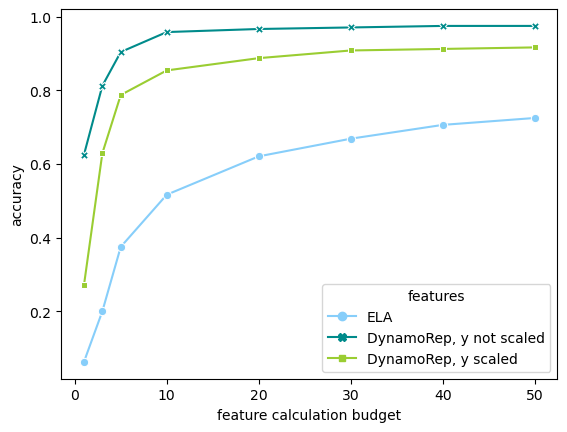

In [95]:
ela_accuracies=all_accuracies
ela_accuracies_by_iteration=ela_accuracies.groupby(['feature calculation budget']).median()['accuracy']
print(ela_accuracies)

dynamorep_accuracies=pd.read_csv(f'problem_classification_visualizations/accuracies_dim_5.csv',index_col=0)
print(dynamorep_accuracies)
dynamorep_accuracies_by_iteration_and_normalize=dynamorep_accuracies.groupby(['feature calculation budget','normalize_y']).median()['accuracy']


dynamorep_accuracies_by_iteration_and_normalize_i = dynamorep_accuracies_by_iteration_and_normalize.reset_index()
dynamorep_accuracies_by_iteration_and_normalize_i.columns=['feature calculation budget','scale y', 'accuracy']
dynamorep_accuracies_by_iteration_and_normalize_i['features']=dynamorep_accuracies_by_iteration_and_normalize_i['scale y'].apply(lambda x: 'DynamoRep, y scaled' if x==True else 'DynamoRep, y not scaled')


ela_accuracies_by_iteration=ela_accuracies_by_iteration.reset_index()
ela_accuracies_by_iteration.columns=['feature calculation budget','accuracy']
ela_accuracies_by_iteration['features']='ELA'
compare_accuracies=ela_accuracies_by_iteration.append(dynamorep_accuracies_by_iteration_and_normalize_i)

plt.figure()
sns.lineplot(x="feature calculation budget", y="accuracy",
                     hue="features",style="features",markers=True,dashes=False,
                     data=compare_accuracies,palette=color_palette)
#plt.show()
plt.savefig(f'{visualizations_dir}/ela_comparison_dim_5.pdf')

In [ ]:
all_accuracies=pd.DataFrame()
for dimension_index,dimension in enumerate(all_dimensions): #
    
    for algorithm in all_algorithms:
        for train_on_seed_1 in [True]:
            for difference_1 in [False]:
                for end_iteration in [0,2,4,9,19,29,39,49]:
                    seed_accuracy_df,_ = get_seed_accuracies_df(dimension,algorithm, 0, end_iteration, train_on_seed_1, difference_1, seeds)
                    seed_accuracy_df['feature calculation budget (iterations)']=end_iteration+1
                    seed_accuracy_df['algorithm']=algorithm
                    seed_accuracy_df['dimension']=dimension
                    all_accuracies=pd.concat([all_accuracies,seed_accuracy_df])

    
    all_accuracies['Evaluation on trajectories from training seed']=all_accuracies.apply(lambda row: row['train_seed']==row['test_seed'], axis=1)

In [ ]:
fig, axes = plt.subplots(len(all_algorithms),len(all_dimensions), figsize=(8,8), sharex=True, sharey=True)
for dimension_index,dimension in enumerate(all_dimensions):
    for algorithm_index, algorithm in enumerate(all_algorithms):
        algorithm_accuracies=all_accuracies.query('algorithm==@algorithm and dimension==@dimension')
        ax=axes[dimension_index][algorithm_index] if type(axes) is np.ndarray else axes
        ax.set_title(f'Dimension: {dimension} Algorithm: {algorithm}')
        sns.violinplot(data=algorithm_accuracies, x="feature calculation budget (iterations)", y="accuracy", hue='Evaluation on trajectories from training seed', split=True, palette=color_palette[1:3], ax=ax)
        if algorithm_index != 0:
            ax.get_legend().remove()
plt.tight_layout()

plt.savefig(os.path.join(visualizations_dir,f'accuracies_all_algorithms_all_dimensions.pdf'))
plt.show()

In [23]:
global_file_name=get_global_file_name(5,"DE", 0, 49, True,200,False)
file_location=global_file_name+f'_fold_{fold}_feature_importance.csv'

In [26]:
fold_importance_df=pd.read_csv(file_location, index_col=[0],  compression='zip', header=[0,1,2])

In [27]:
fold_importance_df

value                        \
iteration_id                     0                     1   
variable     ela_level.mmce_lda_10 ela_level.mmce_lda_10   
0                              0.0              0.000024   

                                                          \
iteration_id                     2                     3   
variable     ela_level.mmce_lda_10 ela_level.mmce_lda_10   
0                          0.00002              0.000049   

                                                          \
iteration_id                     4                     5   
variable     ela_level.mmce_lda_10 ela_level.mmce_lda_10   
0                         0.000026              0.000026   

                                                          \
iteration_id                     6                     7   
variable     ela_level.mmce_lda_10 ela_level.mmce_lda_10   
0                         0.000024              0.000014   

                                                          ...  \
iteration_id                     8                     9  ...   
variable     ela_level.mmce_lda_10 ela_level.mmce_lda_10  ...   
0                         0.000053              0.000072  ...   

                                                                    \
iteration_id                40                41                42   
variable     nbc.costs_runtime nbc.costs_runtime nbc.costs_runtime   
0                     0.000035          0.000037          0.000112   

                                                                    \
iteration_id                43                44                45   
variable     nbc.costs_runtime nbc.costs_runtime nbc.costs_runtime   
0                     0.000035          0.000092          0.000127   

                                                                    \
iteration_id                46                47                48   
variable     nbc.costs_runtime nbc.costs_runtime nbc.costs_runtime   
0                     0.000157          0.000085          0.000043   

                                
iteration_id                49  
variable     nbc.costs_runtime  
0                     0.000063  

[1 rows x 4500 columns]

In [32]:
all_feature_importances_df.columns=[f'{c[2]}_it_{c[1]}' for c in all_feature_importances_df.columns]

In [33]:
all_feature_importances_df.columns

Index(['ela_level.mmce_lda_10_it_0', 'ela_level.mmce_lda_10_it_1',
       'ela_level.mmce_lda_10_it_2', 'ela_level.mmce_lda_10_it_3',
       'ela_level.mmce_lda_10_it_4', 'ela_level.mmce_lda_10_it_5',
       'ela_level.mmce_lda_10_it_6', 'ela_level.mmce_lda_10_it_7',
       'ela_level.mmce_lda_10_it_8', 'ela_level.mmce_lda_10_it_9',
       ...
       'nbc.costs_runtime_it_44', 'nbc.costs_runtime_it_45',
       'nbc.costs_runtime_it_46', 'nbc.costs_runtime_it_47',
       'nbc.costs_runtime_it_48', 'nbc.costs_runtime_it_49', '_it_', '_it_',
       '_it_', '_it_'],
      dtype='object', length=4504)

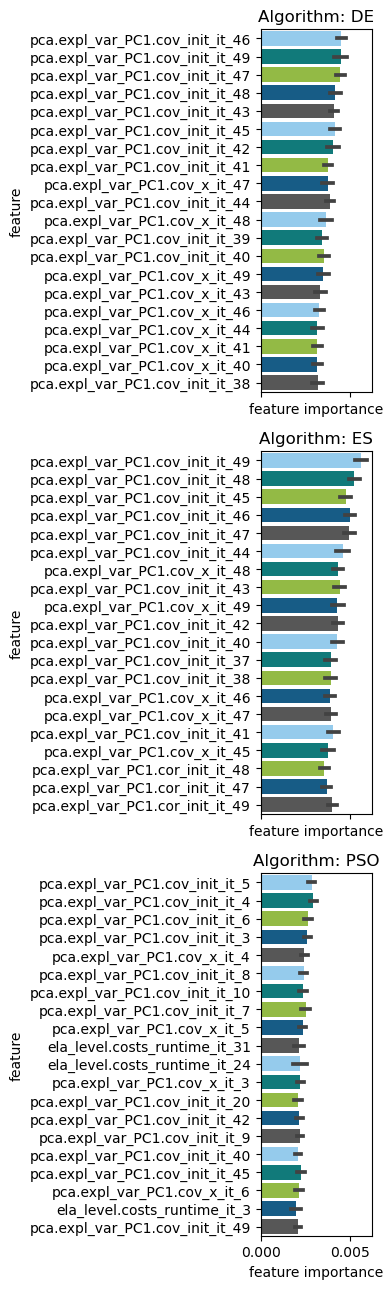

In [35]:

for dimension in [5]:
    for end_iteration in [49]:
        fig, axes = plt.subplots(len(all_algorithms),1, figsize=(4,13), sharex=True)
        for algorithm_index, algorithm in enumerate(all_algorithms):
            all_feature_importances_df=pd.DataFrame()
            for seed in seeds:
                for train_on_seed_1 in [True]:
                    for difference_1 in [False]:

                         for fold in range(0,10):

                            global_file_name=get_global_file_name(dimension,algorithm, 0, end_iteration, train_on_seed,seed, difference)
                            file_location=global_file_name+f'_fold_{fold}_feature_importance.csv'

                            if not os.path.isfile(file_location):
                                print('Not found', file_location)
                                continue
                            #print(file_location)
                            fold_importance_df=pd.read_csv(file_location, index_col=[0], compression='zip', header=[0,1,2])
                            fold_importance_df.columns=[f'{c[2]}_it_{c[1]}' for c in fold_importance_df.columns]
                            fold_importance_df['seed']=seed
                            fold_importance_df['fold']=fold
                            fold_importance_df['algorithm']=algorithm
                            fold_importance_df['budget']=end_iteration+1
                            all_feature_importances_df=pd.concat([all_feature_importances_df, fold_importance_df])
            ax=axes[algorithm_index] if type(axes) is np.ndarray else axes
            ax.set_title(f'Algorithm: {algorithm}')
            id_vars=['algorithm','seed','fold','budget']
            top_features=list(all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(20).index)


            all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_features+id_vars], id_vars=id_vars, value_vars=top_features)
            sns.barplot(all_feature_importances_df_melted, y='variable',x='value',palette=color_palette, ax=ax)
            ax.set_xlabel('feature importance')
            ax.set_ylabel('feature')
        plt.tight_layout()

        plt.savefig(os.path.join(visualizations_dir,'importance_per_algorithm',f'dim_{dimension}_top_20_feature_importance_budget_{end_iteration+1}.pdf'))
        plt.show()

     algorithm  seed  fold  budget                         variable     value
0           DE   200     0      50  pca.expl_var_PC1.cov_init_it_49  0.002832
1           DE   200     1      50  pca.expl_var_PC1.cov_init_it_49  0.003644
2           DE   200     2      50  pca.expl_var_PC1.cov_init_it_49  0.003629
3           DE   200     3      50  pca.expl_var_PC1.cov_init_it_49  0.002530
4           DE   200     4      50  pca.expl_var_PC1.cov_init_it_49  0.004487
...        ...   ...   ...     ...                              ...       ...
2995       PSO  1000     5      50  pca.expl_var_PC1.cov_init_it_36  0.001653
2996       PSO  1000     6      50  pca.expl_var_PC1.cov_init_it_36  0.000931
2997       PSO  1000     7      50  pca.expl_var_PC1.cov_init_it_36  0.003280
2998       PSO  1000     8      50  pca.expl_var_PC1.cov_init_it_36  0.001700
2999       PSO  1000     9      50  pca.expl_var_PC1.cov_init_it_36  0.002048

[3000 rows x 6 columns]


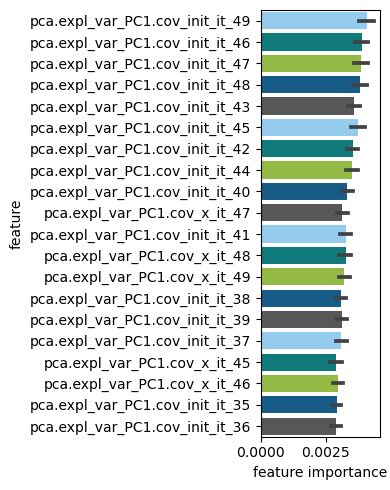

In [48]:
plt.figure( figsize=(4,5))
all_feature_importances_df=pd.DataFrame()
for dimension in [5]:
    for end_iteration in [49]:
        
        for algorithm_index, algorithm in enumerate(all_algorithms):
            
            for seed in seeds:
                for train_on_seed_1 in [True]:
                    for difference_1 in [False]:

                         for fold in range(0,10):

                            global_file_name=get_global_file_name(dimension,algorithm, 0, end_iteration, train_on_seed,seed, difference)
                            file_location=global_file_name+f'_fold_{fold}_feature_importance.csv'

                            if not os.path.isfile(file_location):
                                print('Not found', file_location)
                                continue
                            #print(file_location)
                            fold_importance_df=pd.read_csv(file_location, index_col=[0], compression='zip', header=[0,1,2])
                            fold_importance_df.columns=[f'{c[2]}_it_{c[1]}' for c in fold_importance_df.columns]
                            fold_importance_df['seed']=seed
                            fold_importance_df['fold']=fold
                            fold_importance_df['algorithm']=algorithm
                            fold_importance_df['budget']=end_iteration+1
                            all_feature_importances_df=pd.concat([all_feature_importances_df, fold_importance_df])
        
id_vars=['algorithm','seed','fold','budget']
top_features=list(all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(20).index)


all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_features+id_vars], id_vars=id_vars, value_vars=top_features)
print(all_feature_importances_df_melted)
ax=sns.barplot(all_feature_importances_df_melted, y='variable',x='value',palette=color_palette)
ax.set_xlabel('feature importance')
ax.set_ylabel('feature')
plt.tight_layout()

ax.get_figure().savefig(os.path.join(visualizations_dir,f'dim_{dimension}_top_20_feature_importance_budget_{end_iteration+1}.pdf'))

In [ ]:
id_vars=['algorithm','seed','fold']
top_30_features=list(all_feature_importances_df.drop(columns=id_vars).median().sort_values(ascending=False).head(30).index)


all_feature_importances_df_melted=pd.melt(all_feature_importances_df[top_30_features+id_vars], id_vars=id_vars, value_vars=top_30_features)
plt.figure(figsize=(6,9))

sns.barplot(all_feature_importances_df_melted, y='variable',x='value',palette=color_palette)
plt.tight_layout()
plt.savefig(os.path.join(visualizations_dir,'top_30_feature_importance.pdf'))

In [ ]:
if iteration_end<10:
    all_feature_importances_df_melt=pd.melt(all_feature_importances_df, id_vars=['seed','fold'],value_vars=list(set(all_feature_importances_df.columns).difference({'seed','fold'})), value_name='Importance', var_name='Feature')

    all_feature_importances_df_melt['Feature type']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0])
    all_feature_importances_df_melt['Iteration']=all_feature_importances_df_melt['Feature'].apply(lambda x: int(x.split(' ')[1].split('_')[1]))
    all_feature_importances_df_melt['Feature aggregated across dimensions']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1].split('_')[1])

    all_feature_importances_df_melt=all_feature_importances_df_melt.sort_values(['Iteration','Feature type'])

    #plt.figure(figsize=(40,10))
    fig, axes= plt.subplots(1,1,figsize=(10,3), sharey=True)
    sns.boxplot(all_feature_importances_df_melt.query('Iteration<10'),y='Importance', x='Feature aggregated across dimensions',  palette=color_palette_4, ax=axes)
    axes.tick_params(axis='x', labelrotation=90)

    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_feature_importance_across_iterations.pdf'))

In [ ]:
if iteration_end>20:
    all_feature_importances_df_melt=pd.melt(all_feature_importances_df, id_vars=id_vars,value_vars=list(set(all_feature_importances_df.columns).difference(set(id_vars))), value_name='Importance', var_name='Feature')

    all_feature_importances_df_melt['Feature type']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0])
    all_feature_importances_df_melt['Iteration']=all_feature_importances_df_melt['Feature'].apply(lambda x: int(x.split(' ')[1].split('_')[1]))
    all_feature_importances_df_melt['Feature aggregated across dimensions']=all_feature_importances_df_melt['Feature'].apply(lambda x: x.split(' ')[0] + ' ' + x.split(' ')[1].split('_')[1])

    all_feature_importances_df_melt=all_feature_importances_df_melt.sort_values(['Iteration','Feature type'])

    #plt.figure(figsize=(40,10))
    fig, axes= plt.subplots(3,1,figsize=(10,8), sharey=True)
    sns.boxplot(all_feature_importances_df_melt.query('Iteration<10'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[0])
    sns.boxplot(all_feature_importances_df_melt.query('Iteration>=10 and Iteration <20'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[1])

    sns.boxplot(all_feature_importances_df_melt.query('Iteration>=20'),y='Importance', x='Feature aggregated across dimensions',  palette=[color_palette_4[1]], ax=axes[2])
    axes[0].tick_params(axis='x', labelrotation=90)
    axes[1].tick_params(axis='x', labelrotation=90)
    axes[2].tick_params(axis='x', labelrotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'all_algs_{iteration_start}-{iteration_end}_feature_importance_across_iterations.pdf'))

In [ ]:
top_feature_importances=[]
feature_importance_scores=pd.DataFrame()
for seed in seeds:
    seed_feature_importances_df=all_feature_importances_df.query('seed==@seed')
    sorted_feature_importance=seed_feature_importances_df.drop(columns=['seed']).median().sort_values(ascending=False).to_frame()
    top_features = list(sorted_feature_importance.index)[:20]+['seed']
    
    sorted_feature_importance['rank']=list(range(0,sorted_feature_importance.shape[0]))
    
    sorted_feature_importance['seed']=seed
    feature_importance_scores=pd.concat([feature_importance_scores,sorted_feature_importance.reset_index()])
    top_feature_importances+=top_features
    all_feature_importances=[]
    for index, row in seed_feature_importance_df[top_features ].iterrows():
        for index2 in row.keys():
            if index2!='seed':
                all_feature_importances+=[(index,index2,row[index2],row['seed'])]
    feature_importance_df=pd.DataFrame(all_feature_importances, columns=['fold','feature_name','importance','seed'])
    plt.figure()
    sns.boxplot(feature_importance_df,y='importance', x='feature_name',  palette=color_palette)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(os.path.join(visualizations_dir,f'{algorithms}_{iteration_start}-{iteration_end}_final_top_20_features_boxplots_seeds_{seed}.pdf'))
print(pd.DataFrame(top_feature_importances).value_counts())
print(feature_importance_scores)
    